## ================================================================
# Purpose:      Python script for Time Series Forecast
# Author:       BC2407-S02 Team 8
# Updated:      03/04/2021
# Topics:       Data Preparation and observations, Differencing and Seasonal Decomposition, Exponential Smoothing (SES,Holt's,Winter's), Arima
# Data Source:  Kaggle E-commerce Data
# Packages:     pandas, numpy, pmdarima, statsmodels, matplotlib
## ================================================================

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

We will read in the data here, as well as include a new column 'Revenue' that will be the total revenue earned from that particular transaction/invoice, i.e Quantity*UnitPrice

In [30]:
df = pd.read_csv('data_final.csv',index_col=0,parse_dates=True, encoding = "ISO-8859-1") 

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


# Data Preparation
From the dataset, we will pull out the columns 'Revenue' and 'InvoiceDate', which are the only ones that will be relevant to our time series forecasting.

The 'InvoiceDate' will be converted to datetime format, and we will obtain new columns 'Year','Month','Week' from this column.

Finally, we are able to group the revenue by the Year,Month and Week. In other words, we are able to obtain the total weekly sales revenue for the e-commerce shop.

In [3]:
sales = df[['Quantity','InvoiceDate']]

sales.loc[:,'InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'])
sales.loc[:,'Year'] = sales['InvoiceDate'].dt.year.to_numpy()
sales.loc[:,'Month'] = sales['InvoiceDate'].dt.month.to_numpy()
sales.loc[:,'Week'] = sales['InvoiceDate'].dt.week.to_numpy()


weekly_sales = sales.groupby(['Year', 'Month','Week']).agg({'Quantity':'sum'}).reset_index()

weekly_sales

C:\Users\colin\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\colin\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,Year,Month,Week,Quantity
0,2010,12,48,72414
1,2010,12,49,99092
2,2010,12,50,93991
3,2010,12,51,29680
4,2011,1,1,68535
...,...,...,...,...
58,2011,11,46,154673
59,2011,11,47,151309
60,2011,11,48,77063
61,2011,12,48,61085


# Time-series of the actual e-commerce sales (Weekly)

After plotting the time series of the revenue earned every week, we were able to get the graph below. We can see that generally there is an upward trend in revenue with respect to time. The time series also suggest that there is seasonality due to the non-stable mean and variance.

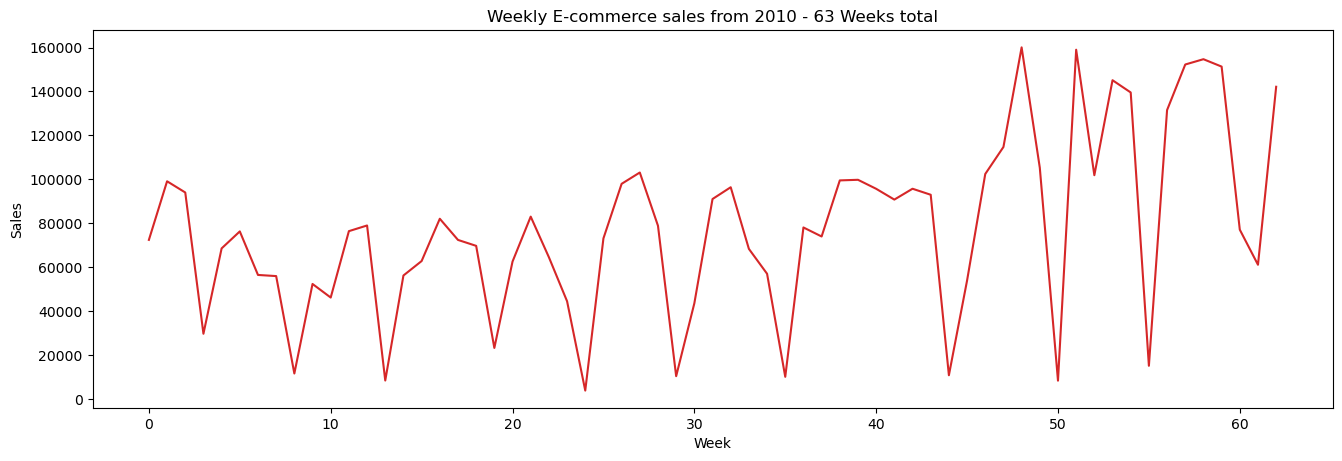

In [4]:
# Draw Time series
def plot_df(weekly_sales, x, y, title="Weekly E-commerce sales from 2010", xlabel='Week', ylabel='Sales', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(weekly_sales, x=weekly_sales.index, y=weekly_sales['Quantity'], 
        title='Weekly E-commerce sales from 2010 - 63 Weeks total')    

# Differencing

Differencing is used to transform the seasonal time series into a stationary time series. As a result, we will be able to remove the impacts of trends and seasonality, making the time series forecasting model accurate and effective.

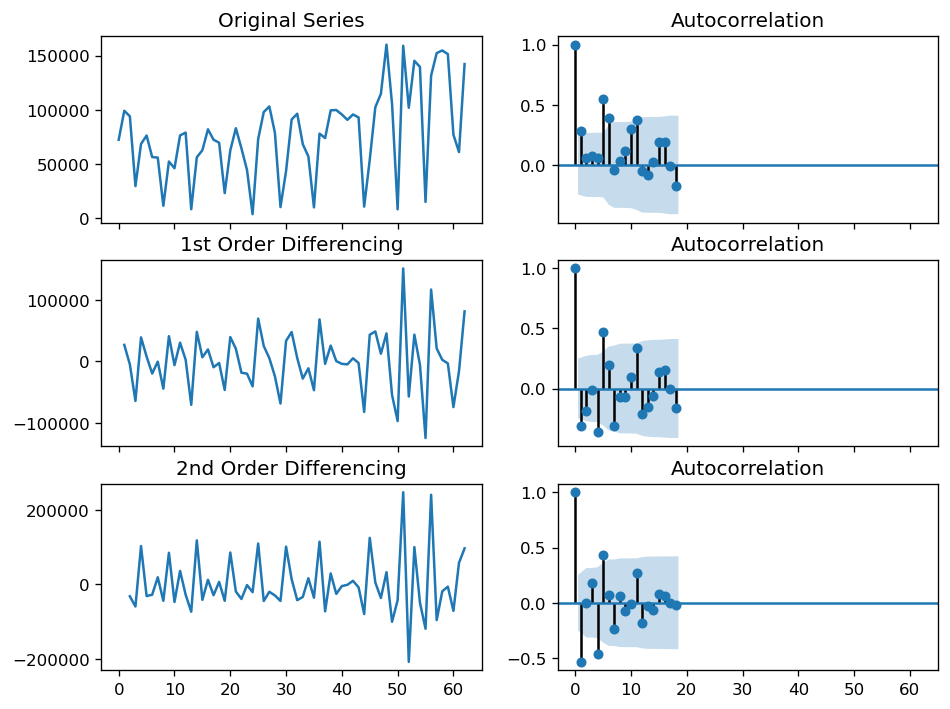

In [5]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(weekly_sales['Quantity']); axes[0, 0].set_title('Original Series')
plot_acf(weekly_sales['Quantity'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(weekly_sales['Quantity'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(weekly_sales['Quantity'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(weekly_sales['Quantity'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(weekly_sales['Quantity'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Although there are some improvement with 1st and 2nd order differencing, the time series still has huge fluctuations over time. As a result, we will be using other techniques to forecast the time series.

# Seasonal decompose 

Seasonal decomposition is done to show the effects of trend and season on the time series. One season is treated to be 4 weeks, which is the equivalent of one month.

The first part will be an Additive Time Series Model

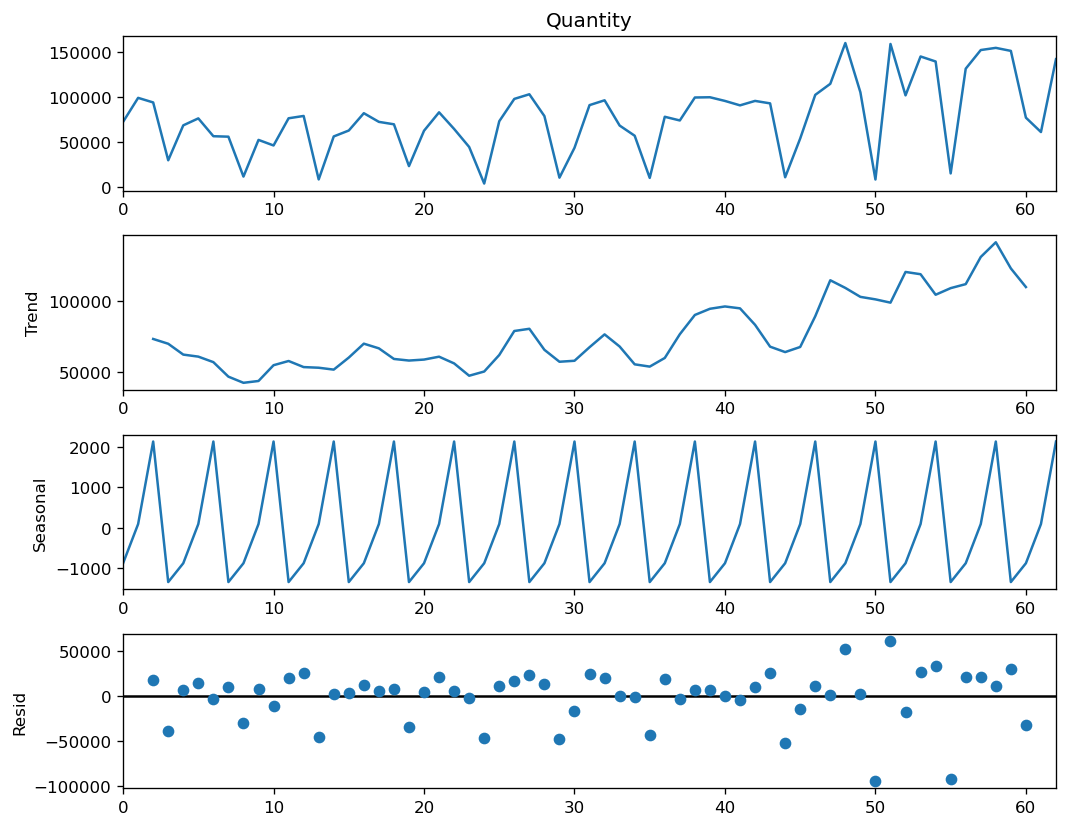

In [6]:
decompose_result = seasonal_decompose(weekly_sales['Quantity'],model='add', period=4)
decompose_result.plot();

Now, we will observe the Multiplicative Time Series Model.

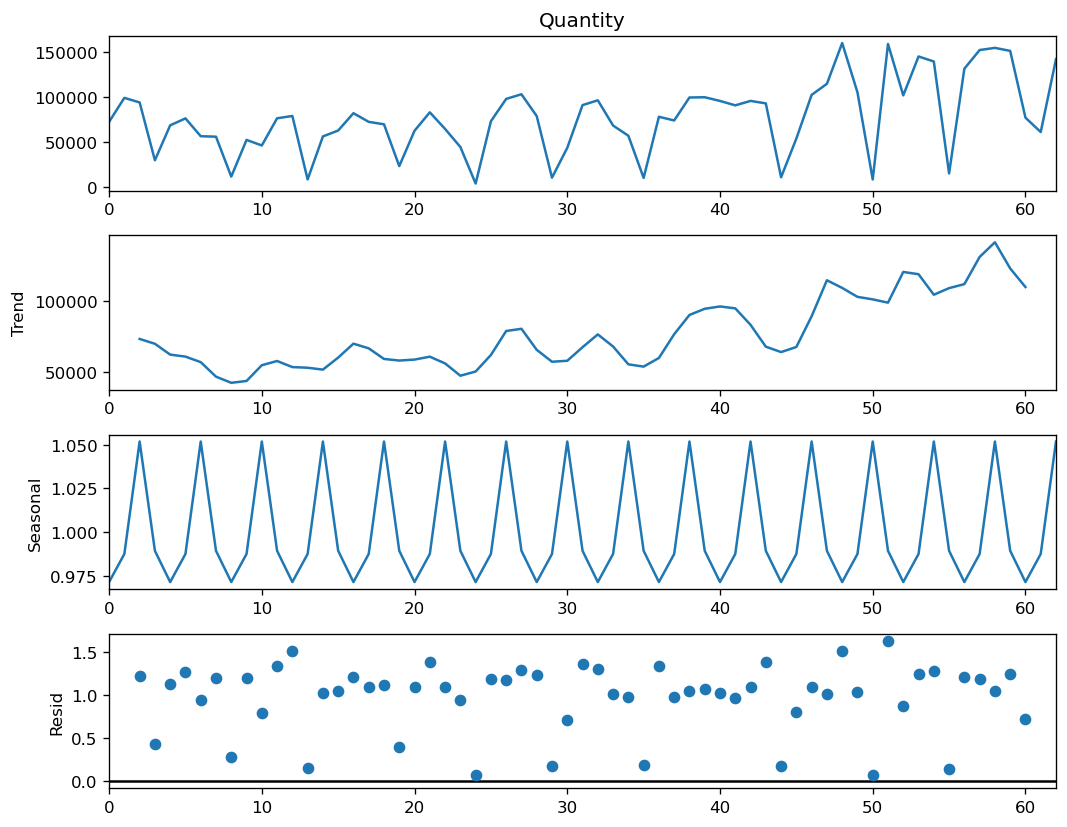

In [7]:
decompose_result = seasonal_decompose(weekly_sales['Quantity'],model='mul', period=4)
decompose_result.plot();

Both additive and multiplicative seasonal breakdown looks similar. Our group choose to use multiplicative due to the non-linear fluctuation in the original time series.

Now, we will move onto the Exponential Smoothing Methods.

# Simple exponential smoothing (No trend, No seasonality)

SES is a time series forecasting method for univariate data that can be extended to support data without a systematic trend or seasonality.

We will plot the graph of the Actual Revenue values against the Predicted values, as well as the Summary of the model results.

One metric to keep in mind from the model results is the AIC (Akaike information criterion, which quantifies the goodness of fit and simplicity of the model. A model with lower AIC value is better. 

Dep. Variable:,endog,No. Observations:,63
Model:,SimpleExpSmoothing,SSE,97003599167.661
Optimized:,False,AIC,1336.757
Trend:,None,BIC,1341.044
Seasonal:,None,AICC,1337.447
Seasonal Periods:,None,Date:,"Sun, 04 Apr 2021"
Box-Cox:,False,Time:,17:24:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
initial_level,72414.000,l.0,False


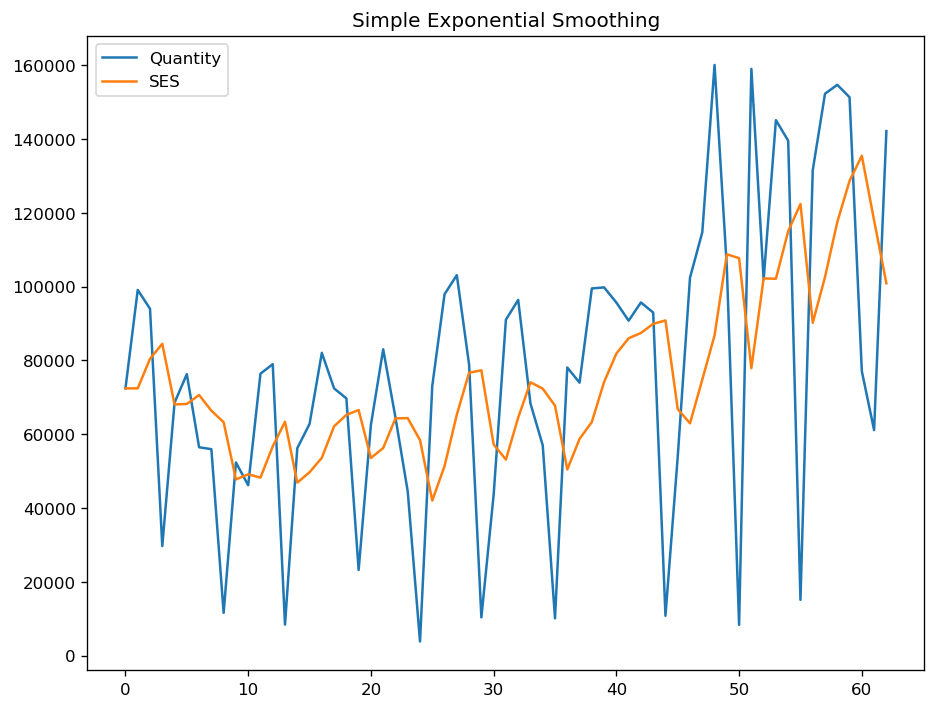

In [8]:
# Set the frequency of the date time index as Monthly start as indicated by the data
weekly_sales.index.freq = 'W'

SES = SimpleExpSmoothing(weekly_sales['Quantity']).fit(smoothing_level=0.3,optimized=False,use_brute=True)

weekly_sales.loc[:,'SES'] = SES.fittedvalues
weekly_sales[['Quantity','SES']].plot(title='Simple Exponential Smoothing');

SES.summary()

As we can observe from the graph plotted above, without trend and seasonality, SES's predicted values are far from the actual ones. Hence, it is inaccurate, and should not be used in this scenario. 

Now, we will move onto the Holt's Method, used for a series with trend but no seasonality

## Holt's method (Trend, No Seasonality) 

Holt's method, also known as double exponential smoothing, is an improvement as it adds the trend component to the time series forecasting model.

We will plot the graph of the Actual Revenue values against the Predicted values, as well as the Summary of the model results.

C:\Users\colin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Dep. Variable:,endog,No. Observations:,63
Model:,ExponentialSmoothing,SSE,87052708028.655
Optimized:,True,AIC,1333.939
Trend:,Multiplicative,BIC,1342.511
Seasonal:,None,AICC,1335.439
Seasonal Periods:,None,Date:,"Sun, 04 Apr 2021"
Box-Cox:,False,Time:,17:24:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1037263,alpha,True
smoothing_slope,0.1001905,beta,True


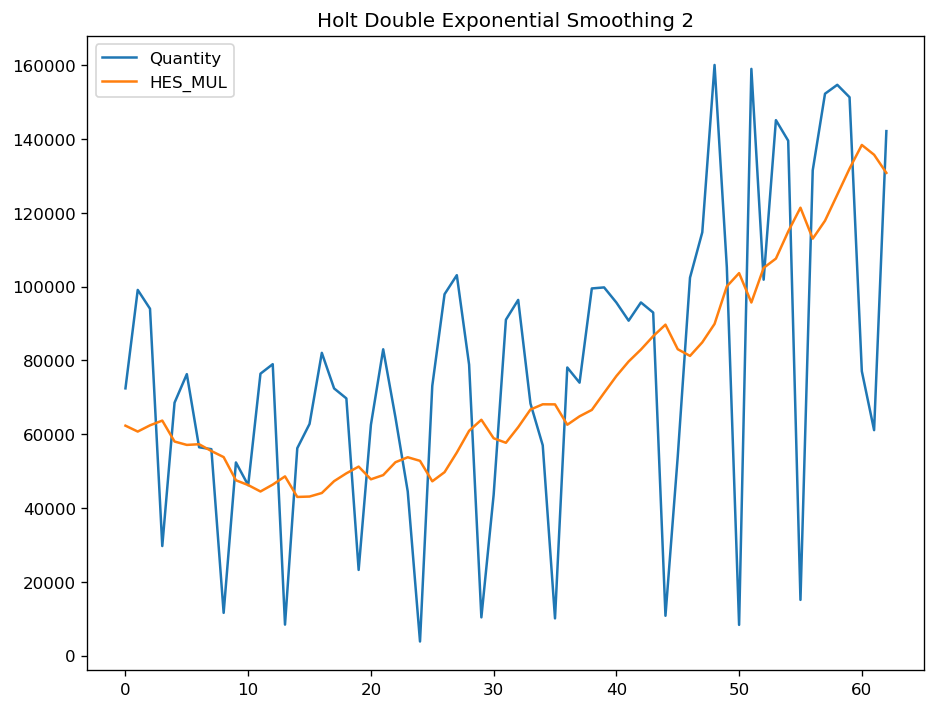

In [9]:
HES = ExponentialSmoothing(weekly_sales['Quantity'],trend='mul', seasonal_periods=4).fit()

weekly_sales.loc[:,'HES_MUL'] = HES.fittedvalues
weekly_sales[['Quantity','HES_MUL']].plot(title='Holt Double Exponential Smoothing 2');

HES.summary()

From the graph above, it is observed that the Holt's Method seems rather effective. The predicted values are extrmely close to the actual values.

For the sake of exploration, we will continue moving on to the Holt-Winter's Method to see if it serves as an even more effective model with more accurate predictions (or smaller RMSE).

## Holt-Winter's method (Exponential Smoothing + trend + seasonality) 

Holt-Winter's method, also known as triple exponential smoothing is an improvement of Holt's method by incorporating seasonality. 

We will plot the graph of the Actual Revenue values against the Predicted values, as well as the Summary of the model results.

C:\Users\colin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\colin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Dep. Variable:,endog,No. Observations:,63
Model:,ExponentialSmoothing,SSE,94201247582.092
Optimized:,True,AIC,1346.911
Trend:,Multiplicative,BIC,1364.056
Seasonal:,Multiplicative,AICC,1351.141
Seasonal Periods:,4,Date:,"Sun, 04 Apr 2021"
Box-Cox:,False,Time:,17:24:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0888240,alpha,True
smoothing_slope,0.0887947,beta,True


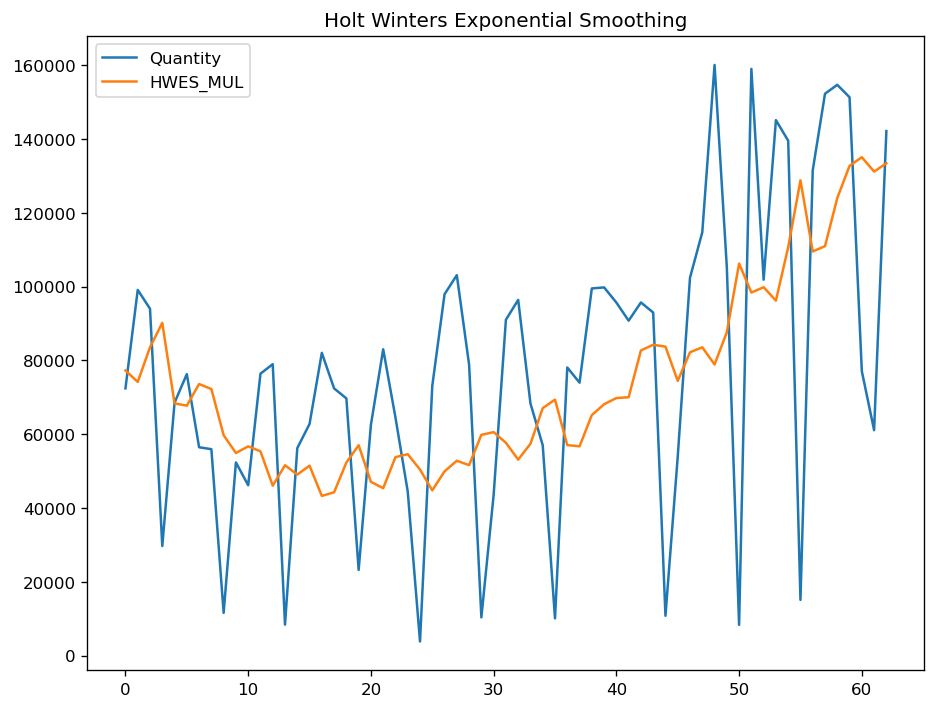

In [10]:
HWES = ExponentialSmoothing(weekly_sales['Quantity'],trend='mul', seasonal='mul', seasonal_periods=4).fit()

weekly_sales.loc[:,'HWES_MUL'] = HWES.fittedvalues
weekly_sales[['Quantity','HWES_MUL']].plot(title='Holt Winters Exponential Smoothing');

HWES.summary()

From the graph above, it is observed that the Holt-Winters' Method seems rather effective, or at the very least, more effective than the SES method. 

However, based on our preliminary observations (by comparing the graphs), it seems that the Holt's Method seems to be more effective than the Holt-Winter's Method. This hypothesis will be further evaluated by looking at the RMSE and MAE values for the 3 different Exponential Smoothing methods.

The next graph shown will be all 3 Exponential Smoothing Methods plotted against the Actual Revenue values.

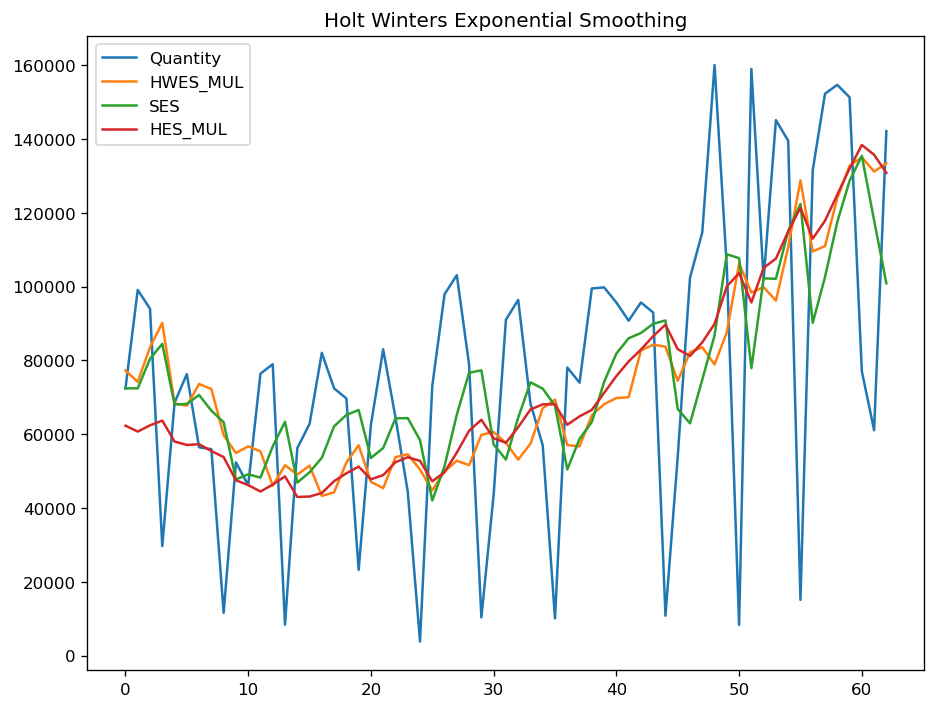

In [11]:
weekly_sales[['Quantity','HWES_MUL','SES','HES_MUL']].plot(title='Holt Winters Exponential Smoothing');

# Further evaluation of the 3 Exponential Smoothing Methods

Since RMSE, MAE is not provided by the library, we have to create a new function to calculate these metrics based on the predicted vs actual revenue in the time series forecast.

In [12]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

In [13]:
SES_forecast_accuracy = forecast_accuracy(weekly_sales['SES'],weekly_sales['Quantity'])
print(SES_forecast_accuracy)

{'mape': 1.2859158775267099, 'me': -2160.666755622874, 'mae': 30250.7673767895, 'mpe': 0.9780707601487851, 'rmse': 39239.51668061102, 'corr': 0.33048365637189914, 'minmax': 0.3239993526059195}


In [14]:
HES_forecast_accuracy = forecast_accuracy(weekly_sales['HES_MUL'],weekly_sales['Quantity'])
print(HES_forecast_accuracy)

{'mape': 1.1866466712343, 'me': -4410.859185086142, 'mae': 29497.997609784015, 'mpe': 0.8373999882103508, 'rmse': 37172.42279335392, 'corr': 0.4591502054101596, 'minmax': 0.3329011311047222}


In [15]:
HWES_forecast_accuracy = forecast_accuracy(weekly_sales['HWES_MUL'],weekly_sales['Quantity'])
print(HWES_forecast_accuracy)

{'mape': 1.2179880307069533, 'me': -3619.2496228775176, 'mae': 31004.966216803088, 'mpe': 0.8704917741476117, 'rmse': 38668.5647280637, 'corr': 0.3903320597811632, 'minmax': 0.34515268284675715}


In [16]:
print('Holt-Winters RMSE: ', HWES_forecast_accuracy.get('rmse') ,'\n' 
      'Holt RMSE: ', HES_forecast_accuracy.get('rmse') ,'\n' 
      'SES RMSE:', SES_forecast_accuracy.get('rmse'), '\n')

print('Holt-Winters MAE: ', HWES_forecast_accuracy.get('mae') ,'\n' 
      'Holt MAE: ', HES_forecast_accuracy.get('mae') ,'\n' 
      'SES MAE:', SES_forecast_accuracy.get('mae'))

Holt-Winters RMSE:  38668.5647280637 
Holt RMSE:  37172.42279335392 
SES RMSE: 39239.51668061102 

Holt-Winters MAE:  31004.966216803088 
Holt MAE:  29497.997609784015 
SES MAE: 30250.7673767895


# Conclusions for 3 Exponential Smoothing Methods

Based on the RMSE and MAE Values for the 3 Models, it appears that Holt-Winters' Method observed the lowest RMSE and MAE values out of all 3. Hence, we can conclude that the Holt-Winters' Method is the most accurate amongst all 3 Exponential Smoothing Methods.

# ARIMA model

Besides the forecast models that uses exponential smoothing, we will also be looking at the ARIMA model. ARIMA stands for Auto Regressive Integrated Moving Average that uses the past values of the time series to forecast future values.

## Non-seasonal

We set the model to run a forecast model without seasonality for our reference.

Afterwards, we will print the summary of the Non-Seasonal ARIMA Model. Likewise, the AIC Value can be observed from this model summary for comparison between models.

In [17]:
model = pm.auto_arima(weekly_sales['Quantity'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1518.876, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1614.696, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1538.181, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1583.873, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1519.819, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1581.863, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1535.607, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1514.218, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1542.437, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1517.560, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1516.828, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1519.138, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1520.562, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : 

Text(0.5, 1.0, 'ARIMAX Forecast of e-commerce sales, Non-Seasonal')

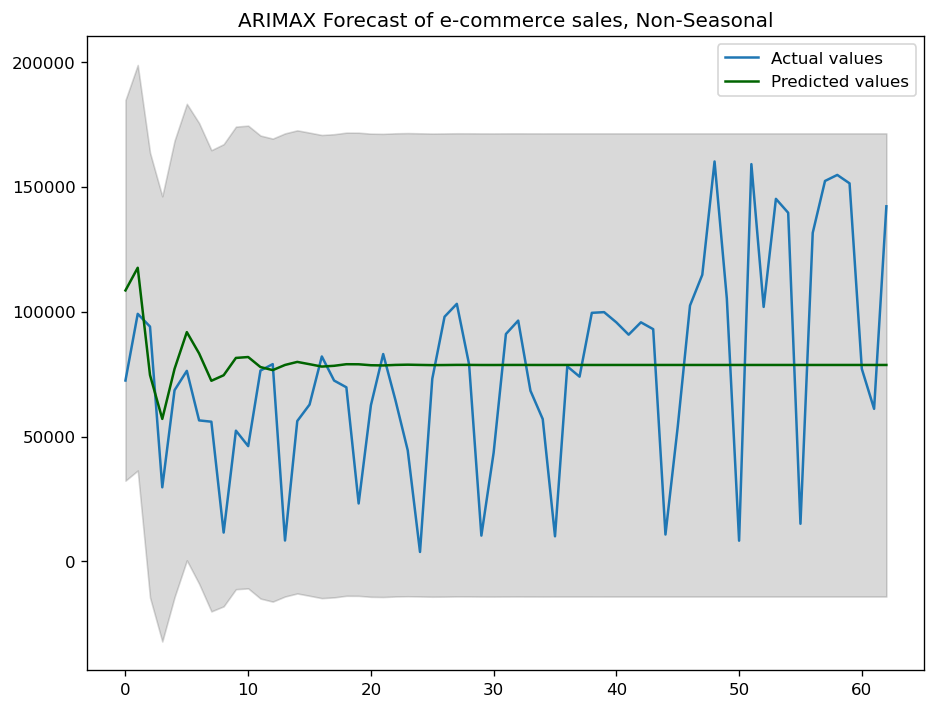

In [18]:
# Forecast 
n_periods = 63
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(0, n_periods)

# # make series for plotting purpose
fitted_series = pd.Series(fitted,index=index_of_fc)
lower_series = pd.Series(confint[:, 0],index=index_of_fc)
upper_series = pd.Series(confint[:, 1],index=index_of_fc)

# # Plot
plt.plot(weekly_sales['Quantity'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)


plt.legend(['Actual values','Predicted values'])

plt.title('ARIMAX Forecast of e-commerce sales, Non-Seasonal')

From the graph of the ARIMA model plotted above, we can see clearly that without seasonal effects, the predicted values are inaccurate and far from the actual values. 

For the sake of further exploration, we will plot the diagnostics of the model below.

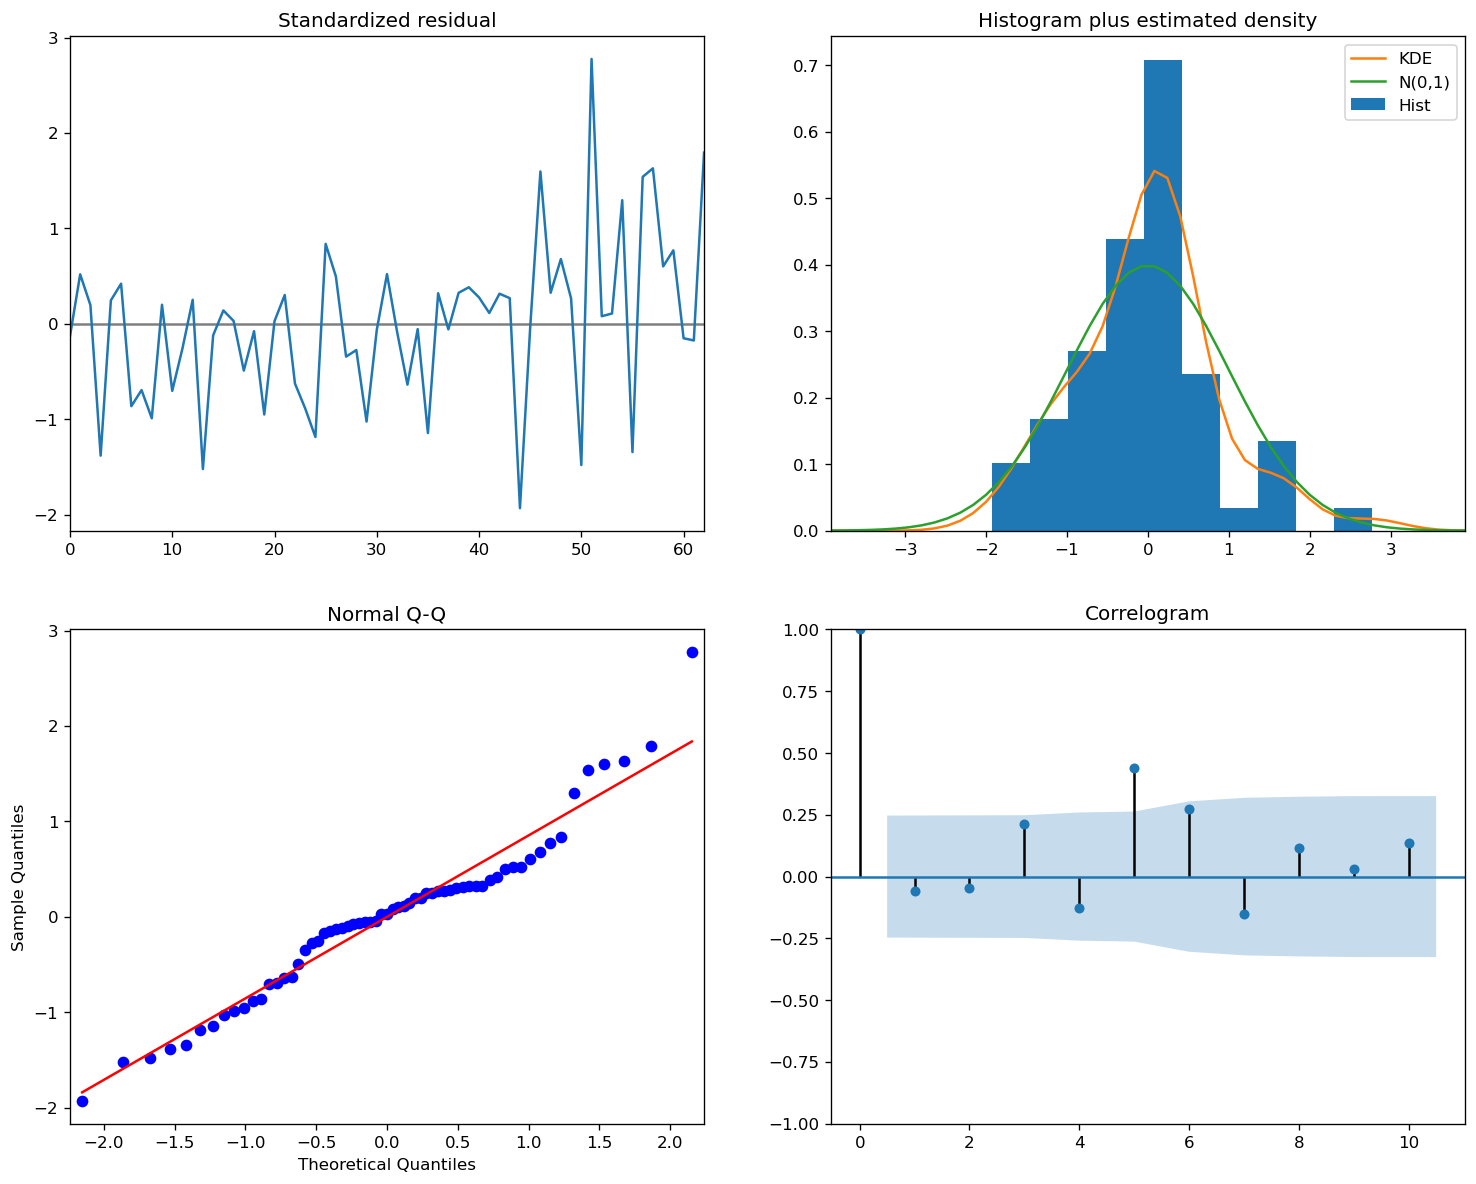

In [19]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Residuals refer to the difference between the observations (actual data) and the fitted values (predicted).

The cell below will look at the RMSE and MAE values for this non-seasonal ARIMA model, for comparison later on.

In [20]:
ARIMA_forecast_accuracy = forecast_accuracy(fitted,weekly_sales['Quantity'])
print(ARIMA_forecast_accuracy)

{'mape': 1.3343365704566978, 'me': 1808.981536188423, 'mae': 31794.076109562837, 'mpe': 1.0993052108773902, 'rmse': 40438.10330194267, 'corr': 0.09643829651615837, 'minmax': 0.3297074558921068}



# Seasonal ARIMA


Next, we will run ARIMA while setting the seasonal period to be 4 weeks.

We will also print the summary of the Non-Seasonal ARIMA Model.

In [21]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(weekly_sales['Quantity'],
                         test='adf',
                         max_p=5, max_q=5, m=4,
                         start_P=1, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=1431.990, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=1460.294, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=1449.600, Time=0.03 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=1438.163, Time=0.04 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=1458.526, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[4] intercept   : AIC=1438.377, Time=0.13 sec
 ARIMA(2,0,2)(1,1,0)[4] intercept   : AIC=1444.077, Time=0.11 sec
 ARIMA(2,0,2)(2,1,1)[4] intercept   : AIC=1441.543, Time=0.21 sec
 ARIMA(2,0,2)(1,1,2)[4] intercept   : AIC=1433.643, Time=0.63 sec
 ARIMA(2,0,2)(0,1,0)[4] intercept   : AIC=1447.625, Time=0.08 sec
 ARIMA(2,0,2)(0,1,2)[4] intercept   : AIC=1431.813, Time=0.67 sec
 ARIMA(1,0,2)(0,1,2)[4] intercept   : AIC=1438.200, Time=0.28 sec
 ARIMA(2,0,1)(0,1,2)[4] intercept   : AIC=1437.253, Time=0.23 sec
 ARIMA(3,0,2)(0,1,2)[4] intercept   : AIC=1431.347, Time=0.48 sec
 ARIMA(3,0,2)(0,1,1)[4] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   63
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 4)   Log Likelihood                -706.674
Date:                           Sun, 04 Apr 2021   AIC                           1431.347
Time:                                   17:24:35   BIC                           1450.045
Sample:                                        0   HQIC                          1438.646
                                            - 63                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7566.3530   6941.996      1.090      0.276   -6039.709    2.12e+04
ar.L1          0.5435      0.653      0.832      0.405      -0.737       1.824
ar.L2         -0.8694      0.484     -1.798      0.072      -1.817       0.078
ar.L3         -0.1610      0.557     -0.289      0.773      -1.253       0.931
ma.L1         -0.6322      0.651     -0.971      0.332      -1.909       0.644
ma.L2          0.8885      0.623      1.426      0.154      -0.333       2.110
ma.S.L4       -1.0064      0.479     -2.100      0.036      -1.946      -0.067
ma.S.L8        0.3365      0.557      0.604      0.546      -0.756       1.429
sigma2       2.81e+09      0.001   2.39e+12      0.000    2.81e+09    2.81e+09
===================================================================================
Ljung-Box (Q):                       33.79   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.74   Prob(JB):                         0.78
Heteroskedasticity (H):               2.59   Skew:                            -0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+29. Standard errors may be unstable.
"""

Text(0.5, 1.0, 'SARIMAX Forecast of e-commerce sales, Seasonal')

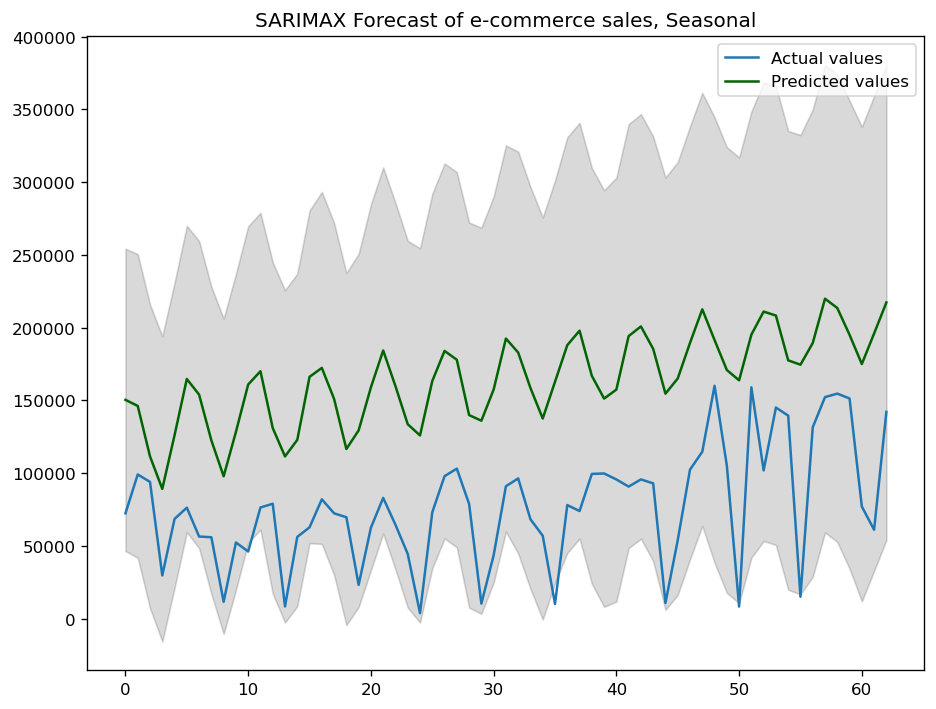

In [22]:
# Forecast 
n_periods = 63
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(0, n_periods)

# # make series for plotting purpose
fitted_series = pd.Series(fitted,index=index_of_fc)
lower_series = pd.Series(confint[:, 0],index=index_of_fc)
upper_series = pd.Series(confint[:, 1],index=index_of_fc)

# # Plot
plt.plot(weekly_sales['Quantity'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(['Actual values','Predicted values'])
plt.title("SARIMAX Forecast of e-commerce sales, Seasonal")

From the graph of the ARIMA model plotted above, we can see that with seasonal effects, there has been an improvement in the predictive power of the model. In particular, the shape of the predicted graph is much more similar to the actual graph. However, the values are still largely different, in that the predicted values are almost twice the values of the actual.

For the sake of further exploration, we will plot the diagnostics of the model below.

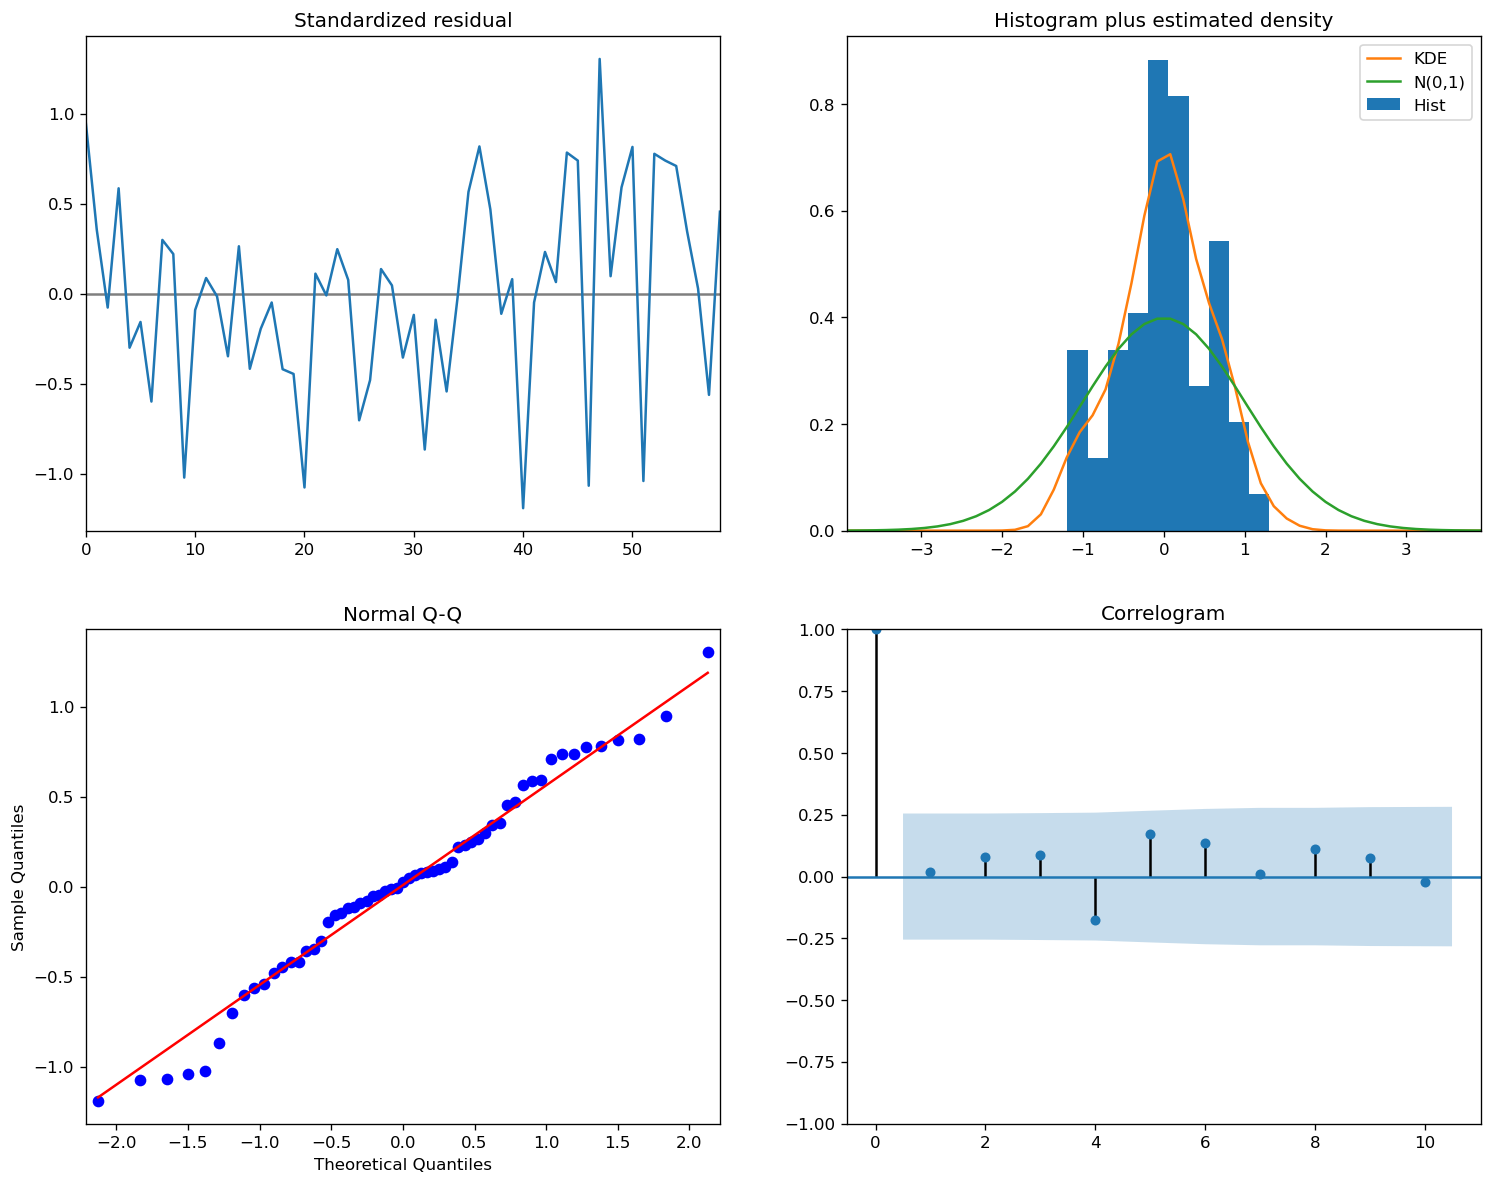

In [23]:
smodel.plot_diagnostics(figsize=(15, 12))
plt.show()

The cell below will look at the RMSE and MAE values for this seasonal ARIMA model, for comparison later on.

In [24]:
SARIMA_forecast_accuracy = forecast_accuracy(fitted,weekly_sales['Quantity'])
print(SARIMA_forecast_accuracy)

{'mape': 2.9206460905801053, 'me': 86474.29633670195, 'mae': 86474.29633670195, 'mpe': 2.9206460905801053, 'rmse': 91619.04168258002, 'corr': 0.6692707723741428, 'minmax': 0.5412524070440247}


# Evaluation of all the models

Now that we have gotten up to 5 different time-forecasting models, we will perform the final evaluation and conclusions.

In [25]:
print("SES: \n", SES_forecast_accuracy )
print("\n HES \n: ", HES_forecast_accuracy)
print("\n HWES: \n", HWES_forecast_accuracy)
print("\n ARIMA: \n", ARIMA_forecast_accuracy)
print("\n SARIMA: \n", SARIMA_forecast_accuracy)

SES: 
 {'mape': 1.2859158775267099, 'me': -2160.666755622874, 'mae': 30250.7673767895, 'mpe': 0.9780707601487851, 'rmse': 39239.51668061102, 'corr': 0.33048365637189914, 'minmax': 0.3239993526059195}

 HES 
:  {'mape': 1.1866466712343, 'me': -4410.859185086142, 'mae': 29497.997609784015, 'mpe': 0.8373999882103508, 'rmse': 37172.42279335392, 'corr': 0.4591502054101596, 'minmax': 0.3329011311047222}

 HWES: 
 {'mape': 1.2179880307069533, 'me': -3619.2496228775176, 'mae': 31004.966216803088, 'mpe': 0.8704917741476117, 'rmse': 38668.5647280637, 'corr': 0.3903320597811632, 'minmax': 0.34515268284675715}

 ARIMA: 
 {'mape': 1.3343365704566978, 'me': 1808.981536188423, 'mae': 31794.076109562837, 'mpe': 1.0993052108773902, 'rmse': 40438.10330194267, 'corr': 0.09643829651615837, 'minmax': 0.3297074558921068}

 SARIMA: 
 {'mape': 2.9206460905801053, 'me': 86474.29633670195, 'mae': 86474.29633670195, 'mpe': 2.9206460905801053, 'rmse': 91619.04168258002, 'corr': 0.6692707723741428, 'minmax': 0.541

In [26]:
print('Holt-Winters RMSE: ', HWES_forecast_accuracy.get('rmse') ,'\n' 
      'Holt RMSE: ', HES_forecast_accuracy.get('rmse') ,'\n' 
      'SES RMSE: ', SES_forecast_accuracy.get('rmse'), '\n'
     'Arima RMSE: ', ARIMA_forecast_accuracy.get('rmse'), '\n'
     'SArima RMSE: ', SARIMA_forecast_accuracy.get('rmse'), '\n')

print('Holt-Winters MAE: ', HWES_forecast_accuracy.get('mae') ,'\n' 
      'Holt MAE: ', HES_forecast_accuracy.get('mae') ,'\n' 
      'SES MAE: ', SES_forecast_accuracy.get('mae'), '\n'
     'Arima MAE: ', ARIMA_forecast_accuracy.get('mae'), '\n'
     'SArima MAE: ', SARIMA_forecast_accuracy.get('mae'),'\n')

print('Holt-Winters AIC: ', HWES.aic ,'\n' 
      'Holt AIC: ', HES.aic ,'\n' 
      'SES AIC: ', SES.aic, '\n'
     'Arima AIC: ', model.aic, '\n' #1512.192
     'SArima AIC: ', smodel.aic) #1428.809

Holt-Winters RMSE:  38668.5647280637 
Holt RMSE:  37172.42279335392 
SES RMSE:  39239.51668061102 
Arima RMSE:  40438.10330194267 
SArima RMSE:  91619.04168258002 

Holt-Winters MAE:  31004.966216803088 
Holt MAE:  29497.997609784015 
SES MAE:  30250.7673767895 
Arima MAE:  31794.076109562837 
SArima MAE:  86474.29633670195 

Holt-Winters AIC:  1346.9105657693076 
Holt AIC:  1333.9386277658791 
SES AIC:  1336.757389171042 
Arima AIC:  <function ARIMA.aic at 0x000001C60F0605E0> 
SArima AIC:  <function ARIMA.aic at 0x000001C60F060670>


# Conclusion

In conclusion, we have looked at a total of 5 different models for time series forecasting. In general, it is identified that trend and seasonality has great impact on the result of the forecast. Hence, it is best to use models such as Seasonal Arima and/or Holt-Winters' method.